In [84]:
%%capture
!pip install gcsfs

In [85]:
import math

import gcsfs
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader
from tqdm import tqdm, trange

### Read the dataset

In [86]:
# DATA_PATH = "/kaggle/input/riiid-test-answer-prediction/"
DATA_PATH = "gs://kds-e80dfc3d272252bbf34c627d756f891826dab0c19f30ec0fc3ac1979"

In [87]:
dtypes_train = {
    'row_id': 'int64',
    'timestamp': 'int64',
    'user_id': 'int32',
    'content_id': 'int16',
    'content_type_id': 'int8',
    'task_container_id': 'int16',
    'user_answer': 'int8',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'boolean'
    }

dtypes_questions = {
    "question_id": "",
    "bundle_id": "",
    "correct_answer": "",
    "part": "",
    "tags": "",
}

dtypes_lectures = {
    "lecture_id": "",
    "part": "",
    "tag": "",
    "type_of": "",
}

In [88]:
train_df = pd.read_csv(DATA_PATH + "/train.csv", dtype=dtypes_train, nrows=1e6)
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [89]:
questions_df = pd.read_csv(DATA_PATH + "/questions.csv")
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [90]:
lectures_df = pd.read_csv(DATA_PATH + "/lectures.csv")
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [91]:
# removing lecture rows.
train_df = train_df[train_df.answered_correctly != -1]

In [92]:
train_df = train_df.join(questions_df, on="content_id")
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0,0,115,5692,0,1,3,1,NaN,<NA>,5692,5692,3,5,151
1,1,56943,115,5716,0,2,2,1,37000.0,False,5716,5716,2,5,168
2,2,118363,115,128,0,0,0,1,55000.0,False,128,128,0,1,131 149 92
3,3,131167,115,7860,0,3,0,1,19000.0,False,7860,7860,0,1,131 104 81
4,4,137965,115,7922,0,4,1,1,11000.0,False,7922,7922,1,1,131 149 92


In [93]:
drop_cols = [
             "row_id", 
             "timestamp", 
             "content_type_id", 
             "user_answer", 
             "prior_question_had_explanation", 
             "question_id", 
             "bundle_id", 
             "correct_answer", 
             "tags"
             ]
train_df = train_df.drop(drop_cols, axis=1)
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
0,115,5692,1,1,NaN,5
1,115,5716,2,1,37000.0,5
2,115,128,0,1,55000.0,1
3,115,7860,3,1,19000.0,1
4,115,7922,4,1,11000.0,1


In [94]:
# 0 is used for padding, so increment 1
indicator_cols = ["content_id", "task_container_id", "part"]
for c in indicator_cols:
  train_df[c] = train_df[c] + 1
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
0,115,5693,2,1,NaN,6
1,115,5717,3,1,37000.0,6
2,115,129,1,1,55000.0,2
3,115,7861,4,1,19000.0,2
4,115,7923,5,1,11000.0,2


In [95]:
# convert milliseconds to minutes.
train_df['prior_question_elapsed_time'] = train_df["prior_question_elapsed_time"].fillna(0).astype(np.float32) / 60000
train_df.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
0,115,5693,2,1,0.000000,6
1,115,5717,3,1,0.616667,6
2,115,129,1,1,0.916667,2
3,115,7861,4,1,0.316667,2
4,115,7923,5,1,0.183333,2


In [96]:
user_groups = train_df.groupby("user_id")
len(user_groups)

3824

### Pytorch Iterable Dataset

In [97]:
# just some stuff I ctrl C ctrl V from StackOverflow (with little changes)
# [1,2,3,4] --- w = 2 --[[1,2], [2,3], [3,4]] but 2D to 3D
def rolling_window(a, w):
    s0, s1 = a.strides
    m, n = a.shape
    return np.lib.stride_tricks.as_strided(
        a, 
        shape=(m-w+1, w, n), 
        strides=(s0, s0, s1)
    )

def make_timeseries(x, window_length):
  """
  x - shape (seq_len, features)
  """
  # pad a lot of 0s before so when we create windows, we will have appropriate padding.
  x = np.pad(x, ((window_length-1, 0), (0, 0)), constant_values=0) # add padding to the first dimension
  
  # roll windows 
  x = rolling_window(x, window_length) # shape will become - (seq_len, window_length, features)

  return x

def add_features_to_user_df(user_df):

  # shifted answered_correctly, SOS 3
  user_df["answered_correctly"] = user_df["answered_correctly"].shift(fill_value=2) + 1

  return user_df

class RiidDataset(IterableDataset):
  def __init__(self, user_groups, window_length=128, batch_size=32, n_batches=None):
    super().__init__()
    self.user_groups = user_groups
    self.window_length = window_length
    self.batch_size = batch_size
    self.__len = None
    self.n_batches = n_batches
    if n_batches:
      self.__len = n_batches

  def __len__(self):
    if not self.__len:
      b = 0
      for xb, yb in self:
        b += 1
      self.__len = b
    return self.__len 

  def __iter__(self):
    b = 0
    for user_id, user_df in self.user_groups:
      user_df = user_df.drop(columns="user_id")
      y = user_df["answered_correctly"].to_numpy().copy()
      x = add_features_to_user_df(user_df)

      x = make_timeseries(x, self.window_length)
      x = np.transpose(x, (1, 0, 2)) # reshape to [seq_length, bs, features]
      # y = make_timeseries(np.expand_dims(y, axis=1), self.window_length)
      for i in range(0, x.shape[1], self.batch_size):
          start, end = i, i+self.batch_size
          if end > x.shape[1]: # ignoring last incomplete batches, this ignores users with interaction < batchsize, FIX THIS
                continue
          if self.n_batches and b == self.n_batches:
            raise StopIteration
          yield x[:, start:end, :], y[start:end]
          b += 1

##### Variable Sequence Length Dataset

In [98]:
riid_ds = RiidDataset(user_groups, window_length=2, batch_size=128, n_batches=None)

In [99]:
train_dl = DataLoader(riid_ds, batch_size=None)
x, y = next(iter(train_dl))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([2, 128, 5]), torch.Size([128]), torch.float64, torch.int8)

In [189]:
class RiidVlenDataset(IterableDataset):
  def __init__(self, user_groups, seq_len=1, batch_size=32, n_batches=None):
    super().__init__()
    self.user_groups = user_groups
    self.batch_size = batch_size
    self.seq_len = seq_len
    self.__len = None
    self.n_batches = n_batches
    if n_batches:
      self.__len = n_batches

  def __len__(self):
    if not self.__len:
      b = 0
      for xb, yb in self:
        b += 1
      self.__len = b
    return self.__len 

  def __iter__(self):
    b = 0
    xs, ys = [], []
    for user_id, user_df in self.user_groups:
      user_df = user_df.drop(columns="user_id")
      y = user_df["answered_correctly"].to_numpy().copy()
      if y.shape[0] < self.seq_len:
        continue
      x = add_features_to_user_df(user_df).values
      
      for i in range(0, y.shape[0], self.seq_len):
        start, end = i, i + self.seq_len
        if end > y.shape[0]:
          continue

        xs.append(x[start:end])
        ys.append(y[end-1])
        b += 1
        if b == self.batch_size:
          yield np.transpose(np.stack(xs), (1, 0, 2)), np.stack(ys) # reshape x to [seq_len, bs, n_features]
          b = 0
          xs, ys = [], []


In [204]:
riid_ds = RiidVlenDataset(user_groups, batch_size=128, seq_len=8, n_batches=None)
riid_ds_iter = iter(riid_ds)
xb, yb = next(riid_ds_iter)
xb.shape, yb.shape
xb[:, 0, :], y[0]

(array([[5.69300000e+03, 2.00000000e+00, 3.00000000e+00, 0.00000000e+00,
         6.00000000e+00],
        [5.71700000e+03, 3.00000000e+00, 2.00000000e+00, 6.16666675e-01,
         6.00000000e+00],
        [1.29000000e+02, 1.00000000e+00, 2.00000000e+00, 9.16666687e-01,
         2.00000000e+00],
        [7.86100000e+03, 4.00000000e+00, 2.00000000e+00, 3.16666663e-01,
         2.00000000e+00],
        [7.92300000e+03, 5.00000000e+00, 2.00000000e+00, 1.83333337e-01,
         2.00000000e+00],
        [1.57000000e+02, 6.00000000e+00, 2.00000000e+00, 8.33333358e-02,
         2.00000000e+00],
        [5.20000000e+01, 7.00000000e+00, 2.00000000e+00, 2.83333331e-01,
         2.00000000e+00],
        [5.10000000e+01, 8.00000000e+00, 2.00000000e+00, 2.83333331e-01,
         2.00000000e+00]]), tensor(1, dtype=torch.int8))

In [205]:
xb[:, 1, :], y[1]

(array([[7.89700000e+03, 9.00000000e+00, 2.00000000e+00, 2.66666681e-01,
         2.00000000e+00],
        [7.86400000e+03, 1.00000000e+01, 2.00000000e+00, 2.66666681e-01,
         2.00000000e+00],
        [1.53000000e+02, 1.10000000e+01, 2.00000000e+00, 2.83333331e-01,
         2.00000000e+00],
        [1.05000000e+02, 1.20000000e+01, 1.00000000e+00, 3.66666675e-01,
         2.00000000e+00],
        [1.09000000e+02, 1.30000000e+01, 1.00000000e+00, 3.83333325e-01,
         2.00000000e+00],
        [7.90100000e+03, 1.40000000e+01, 1.00000000e+00, 3.49999994e-01,
         2.00000000e+00],
        [7.90200000e+03, 1.50000000e+01, 2.00000000e+00, 4.00000006e-01,
         2.00000000e+00],
        [7.97200000e+03, 1.60000000e+01, 2.00000000e+00, 3.66666675e-01,
         2.00000000e+00]]), tensor(1, dtype=torch.int8))

In [199]:
_, udf = next(iter(user_groups))
udf.head(16)

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,part
0,115,5693,2,1,0.000000,6
1,115,5717,3,1,0.616667,6
2,115,129,1,1,0.916667,2
3,115,7861,4,1,0.316667,2
4,115,7923,5,1,0.183333,2
5,115,157,6,1,0.083333,2
6,115,52,7,1,0.283333,2
7,115,51,8,1,0.283333,2
8,115,7897,9,1,0.266667,2
9,115,7864,10,1,0.266667,2


In [206]:
train_dl = DataLoader(riid_ds, batch_size=None)
x, y = next(iter(train_dl))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([8, 128, 5]), torch.Size([128]), torch.float64, torch.int8)

In [207]:
y

tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 0], dtype=torch.int8)

In [208]:
len(train_dl)

943

In [209]:
batches = 0
max_batch_size = 0
max_seq_len = 0
for xb, yb in train_dl:
    max_batch_size = max(max_batch_size, xb.size(1))
    max_seq_len = max(max_seq_len, xb.size(0))
    batches += 1
    
max_batch_size, max_seq_len, batches

(128, 8, 943)

##### Padding mask

In [210]:
pad_mask = torch.all(torch.eq(x, 0), dim=-1).T
pad_mask.shape

torch.Size([128, 8])

### Transformer Sequence Classifier.

Positional Encoding

In [211]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [212]:
class TransformerClassifier(nn.Module):
    
    def __init__(self, n_tokens_dict, d_model=512, n_heads=8, hidden_dim=1024, n_layers=1, dropout=0):
        
        super().__init__()
        self.d_model = d_model
        
        # Transformer encoder blocks
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, hidden_dim, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, n_layers)
        
        # Input embeddings for content_id, task_container_id, answered_correctly, prior_question_elapsed_time, part
        self.content_id_emb = nn.Embedding(n_tokens_dict["content_id"], d_model)
        self.task_container_id_emb = nn.Embedding(n_tokens_dict["task_container_id"], d_model)
        self.answered_correctly_emb = nn.Embedding(n_tokens_dict["answered_correctly"], d_model)
        self.part_emb = nn.Embedding(n_tokens_dict["part"], d_model)
        self.prior_question_elapsed_time_emb = nn.Linear(1, d_model, bias=False)
        # Positional Encoding
        self.pos_enc = PositionalEncoding(d_model=d_model, dropout=dropout)

        self.out = nn.Linear(d_model, 1)
        
    def forward(self, x):

        # padding mask
        # src_key_padding_mask =  torch.all(torch.eq(x.squeeze(0), 0), dim=-1).T # shape [bs, seq_len]
        
        # input embedding
        content_id_emb = self.content_id_emb(x[..., 0].long())
        task_container_id_emb = self.task_container_id_emb(x[..., 1].long())
        answered_correctly_emb = self.answered_correctly_emb(x[..., 2].long())
        part_emb = self.part_emb(x[..., 4].long())
        # prior_question_elapsed_time_emb = self.prior_question_elapsed_time_emb(x[..., 3].unsqueeze(-1).float())
        
        # shape [seq_len, bs, d_model]
        input_emb = (content_id_emb 
                     + task_container_id_emb
                     + answered_correctly_emb
                     + part_emb
                     # + prior_question_elapsed_time_emb
                     )
        input_emb = input_emb * math.sqrt(self.d_model) # needed?

        input_emb = self.pos_enc(input_emb) # position encoding
        
        # transformer blocks
        z = self.transformer_encoder(input_emb) # , src_key_padding_mask=src_key_padding_mask) # shape [seq_len, bs, d_model]
        
        # global average pooling over the sequence length dimension
        x = z.mean(dim=0) # shape [bs, d_model]
        
        # output layer
        out = self.out(x) # shape [bs, 1]
        
        return torch.sigmoid(out)
        


In [213]:
n_tokens_dict = {
    "content_id": max(train_df["content_id"]) + 1,
    "task_container_id": max(train_df["task_container_id"]) + 1,
    "answered_correctly": 4, # 0-padding, 1-incorrect, 2-correct, 3-fill value
    "part": max(train_df["part"]) + 1
}

n_tokens_dict

{'answered_correctly': 4,
 'content_id': 13524,
 'part': 9,
 'task_container_id': 7741}

In [214]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [215]:
model = TransformerClassifier(n_tokens_dict).to(device)
model

TransformerClassifier(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (content_id_emb): Embedding(13524, 512)
  (task_container_id_emb): Embedding(7741, 512)
  (answered_correctly_emb): Embedding(4, 512)
  (part_emb): Embedding(9, 512)
  (prior_question_elapsed_time_emb): Linear(in_features=1, out_features=512, bias=False)
  (pos_enc): PositionalEncodi

### Training

In [216]:
epochs = 100
opt = torch.optim.Adam(params=model.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=0.01, steps_per_epoch=len(train_dl), epochs=epochs)
loss_func = nn.BCELoss()

https://pytorch.org/tutorials/beginner/nn_tutorial.html#create-fit-and-get-data

In [217]:
def loss_batch(model, loss_func, X_batch, y_batch, opt=None):

  preds = model(X_batch)
  loss = loss_func(preds, y_batch.unsqueeze(dim=-1))

  if opt is not None:
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), 0.25)
    opt.step()
    opt.zero_grad()

  return loss.item(), X_batch.shape[2]

In [218]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl=None, sched=None):
  epoch_losses = []
  epoch_lrs = []
  for e in range(epochs):
    # train
    lrs = []
    train_losses = []
    val_losses = []

    model.train()
    train_dl = tqdm(train_dl, position=0, leave=True)
    for X_batch, y_batch in train_dl:
      X_batch, y_batch = X_batch.to(device), y_batch.T.type(torch.FloatTensor).to(device)
      train_loss, train_bs = loss_batch(model, loss_func, X_batch, y_batch, opt)
      train_losses.append(train_loss)
      train_loss_mean = sum(train_losses) / len(train_losses)
      lr = opt.param_groups[0]["lr"]
      lrs.append(lr)
      train_dl.set_description(f"Epoch: {e}, RunningLoss: {train_loss_mean:.3f}, InstantLoss: {train_loss:.3f}, LR: {lr:.6f}")
      if sched:
        sched.step()
    epoch_losses.append(train_loss_mean)
    epoch_lrs.append(lr)
    # eval
    # model.eval()
    # with torch.no_grad():
    #   val_losses, val_bss = zip(*[loss_batch(model, loss_func, X_batch, y_batch) for X_batch, y_batch in valid_dl])

    # val_loss = np.sum(np.multiply(val_losses, val_bss)) / np.sum(val_bss)
    # train_dl.set_description(f"Epoch: {e}, Loss: {train_loss}, Val Loss: {val_loss}")

  return epoch_losses, epoch_lrs#, val_losses

In [ ]:
train_losses, lrs = fit(epochs, model, loss_func, opt, train_dl, sched=sched)

Epoch: 0, RunningLoss: 0.634, InstantLoss: 0.647, LR: 0.000426: 100%|██████████| 943/943 [00:20<00:00, 45.77it/s]
Epoch: 1, RunningLoss: 0.626, InstantLoss: 0.677, LR: 0.000505: 100%|██████████| 943/943 [00:20<00:00, 46.17it/s]
Epoch: 2, RunningLoss: 0.626, InstantLoss: 0.725, LR: 0.000635: 100%|██████████| 943/943 [00:20<00:00, 45.94it/s]
Epoch: 3, RunningLoss: 0.639, InstantLoss: 0.655, LR: 0.000815: 100%|██████████| 943/943 [00:20<00:00, 46.40it/s]
Epoch: 4, RunningLoss: 0.626, InstantLoss: 0.652, LR: 0.001043: 100%|██████████| 943/943 [00:20<00:00, 46.14it/s]
Epoch: 5, RunningLoss: 0.624, InstantLoss: 0.673, LR: 0.001316: 100%|██████████| 943/943 [00:20<00:00, 46.00it/s]
Epoch: 6, RunningLoss: 0.626, InstantLoss: 0.659, LR: 0.001633: 100%|██████████| 943/943 [00:20<00:00, 45.31it/s]
Epoch: 7, RunningLoss: 0.621, InstantLoss: 0.647, LR: 0.001988: 100%|██████████| 943/943 [00:20<00:00, 45.82it/s]
Epoch: 8, RunningLoss: 0.612, InstantLoss: 0.631, LR: 0.002378: 100%|██████████| 943/943

In [171]:
import matplotlib.pyplot as plt

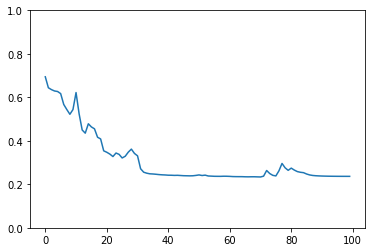

In [172]:
plt.ylim(top=1)
plt.plot(train_losses)

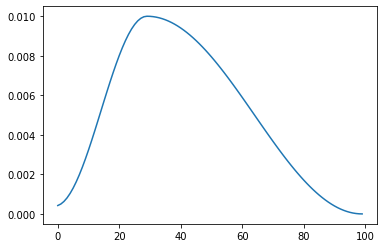

In [173]:
plt.plot(lrs)

In [174]:
xb = xb.to(device)
preds = model(xb)

In [175]:
yb

tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1], dtype=torch.int8)

In [176]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

In [177]:
y_hat = preds.to("cpu").detach().numpy() > 0.5
y_hat = y_hat.astype(np.int8)

In [178]:
y_true = yb.to("cpu").detach().numpy().T
y_true.shape

(128,)

In [179]:
accuracy_score(y_true, y_hat)

0.859375

In [180]:
precision_score(y_true, y_hat)

0.9772727272727273

In [181]:
recall_score(y_true, y_hat)

0.7166666666666667

In [182]:
y_true.T

array([0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1], dtype=int8)

In [183]:
y_hat.T

array([[0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]], dtype=int8)

In [184]:
roc_auc_score(y_true, preds.to("cpu").detach().numpy())

0.9426470588235294